In [1]:
import random
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

USE_REAL_RANDOMNESS = False

if not USE_REAL_RANDOMNESS:
    np.random.seed(sum(ord(c) for c in 'Izan Beltran Ferreiro'))

In [2]:
def drop_random_ball(H: int):
    """Generate the final position of a random ball drop in a galton board.

    Args:
        n: The height of the galton box.

    Returns:
        The final x position of the ball.
    """
    if USE_REAL_RANDOMNESS:
        i = 0
        for _ in range(H):
            # https://docs.python.org/2/library/random.html#random.SystemRandom
            # Uses os.urandom() to get real random numbers. Check your device has a working /dev/random
            if random.SystemRandom().random() <= 1.0/2:
                i += 1
        return i
    else:
        # Faster vectorized version. Gets a random vector from [0,1]^H and counts elements
        # with value < 1/2
        return np.sum(np.random.random(H) < 1.0/2)

In [3]:
def sample_galtonbox_distribution(N: int, H: int):
    """Get N ball drops in a galton board of size n

    Args:
        N: The number of balls to drop
        n: The height of the galton box

    Returns:
        The final x positions of the N balls.
    """
    return [drop_random_ball(H) for _ in range(N)]

In [4]:
def normal_around_point(x):
    return scipy.stats.norm.cdf(x+0.5) - scipy.stats.norm.cdf(x-0.5)


In [5]:
def experiment(H, N, must_plot=True):
    positions = sample_galtonbox_distribution(N, H)
    
    frequencies = {key: 0 for key in range(H+1)}
    for p in positions:
        frequencies[p] += 1
        
    expected_number_of_balls = {k: N*math.comb(H, k)*(1/2)**H for k in frequencies.keys()}
    
    MSE_vs_expected = 1/(H+1) * sum(
        (expected_number_of_balls[k]/N - frequencies[k]/N)**2 for k in frequencies.keys()
    )
    
    MSE_vs_normal = 1/(H+1) * sum(
        (normal_around_point(k) - frequencies[k]/N)**2 for k in frequencies.keys()
    )
    
    if must_plot:
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set(xlabel='ball position', ylabel='density', title=f'Distribution after throwing N={N} balls from height H={H}')
        sns.barplot(x=frequencies.keys(), y=np.array(list(frequencies.values()))/N, width=1, ax=ax, alpha=0.75, label='results')
        x = np.linspace(0, H, 300)
        y = scipy.stats.norm.pdf(x, loc=H/2, scale=math.sqrt(H/4))
        sns.barplot(x=frequencies.keys(), y=np.array(list(expected_number_of_balls.values()))/N, width=1, ax=ax, alpha=0.5, label='Bin$(N, 1/2)$')
        sns.lineplot(x=x, y=y, ax=ax, color='black', alpha=0.5, label='N$(H/2, H/4)$')
        n_xticks = np.clip(H+1, a_min=1, a_max=10)
        ax.set(xticks=np.arange(0, H+1e-9, step=np.floor((H+1)/n_xticks))) 
        plt.grid(True)
        plt.savefig(f'experiemnt-{H}-{N}.svg')
        plt.show()
    
    return MSE_vs_expected, MSE_vs_normal


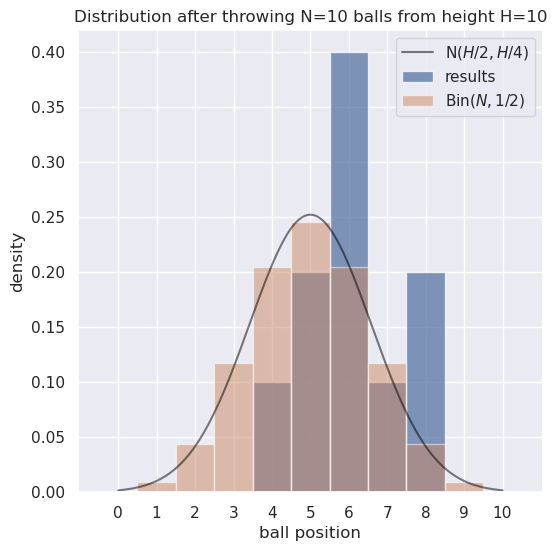

(0.008333254727450286, 0.042611425301500284)

In [6]:
experiment(H=10, N=10)

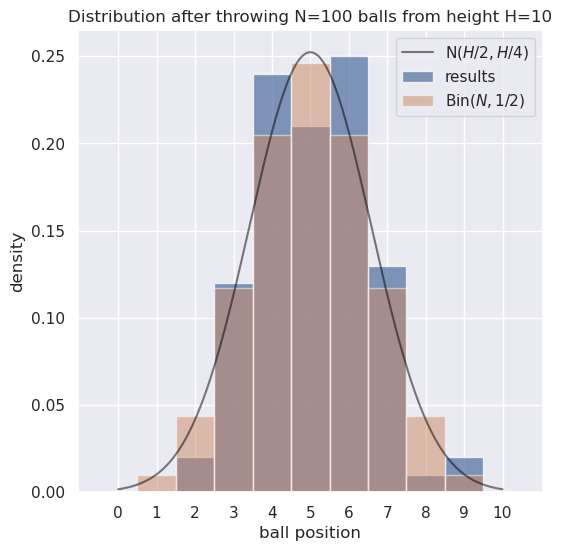

(0.0006036382501775569, 0.03647300377224191)

In [7]:
experiment(H=10, N=100)

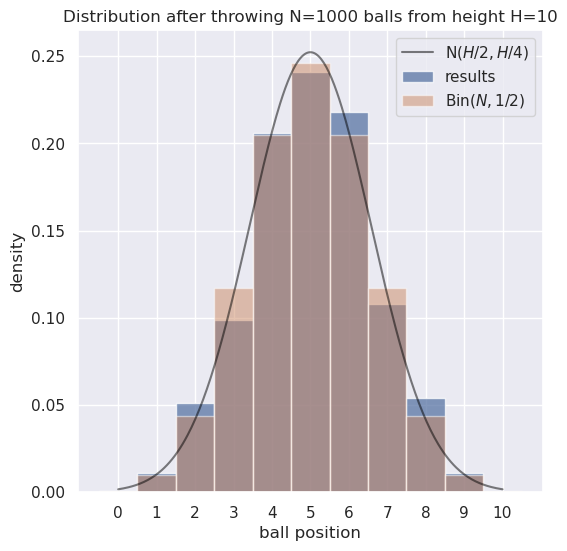

(6.943938654119316e-05, 0.03368131745374053)

In [8]:
experiment(H=10, N=1000)

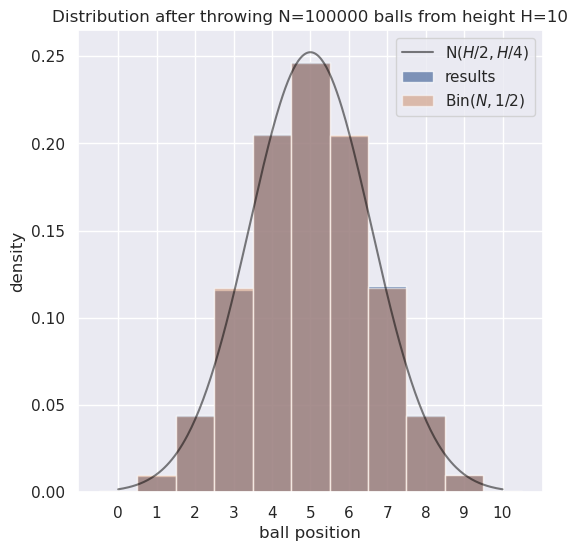

(3.694484730113607e-07, 0.0338937825091611)

In [9]:
experiment(H=10, N=100000)

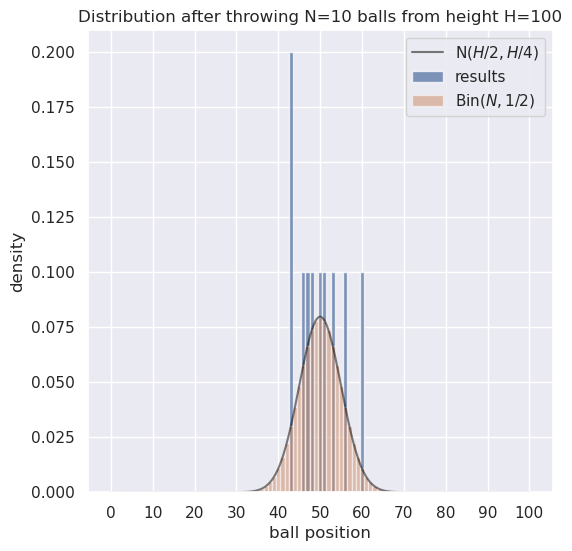

(0.0006921274717542522, 0.0032551771409769364)

In [10]:
experiment(H=100, N=10)

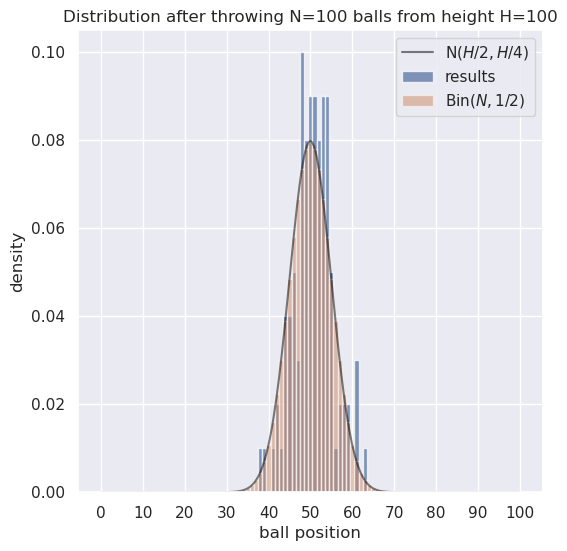

(6.277551127577124e-05, 0.002734385061769015)

In [11]:
experiment(H=100, N=100)

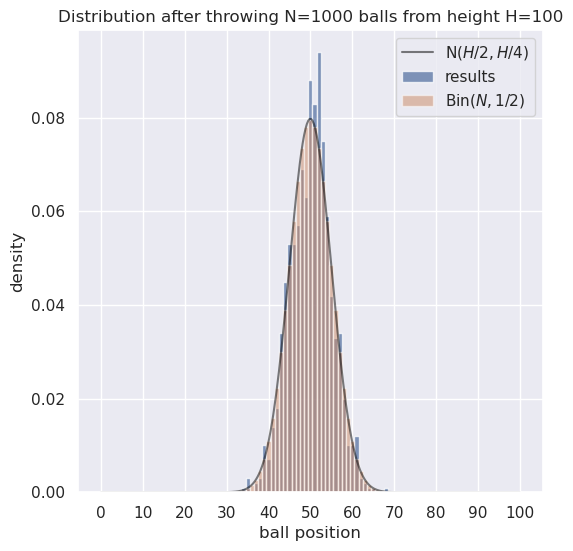

(1.2257938741876794e-05, 0.0026493751607789143)

In [12]:
experiment(H=100, N=1000)

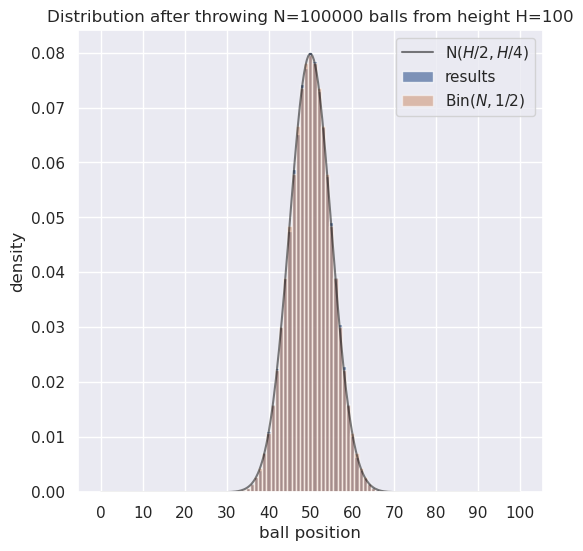

(8.253339891076548e-08, 0.0026246456122640638)

In [13]:
experiment(H=100, N=100000)

In [14]:
def plot_error(Hlist, errorname):
    fig, ax = plt.subplots(figsize=(6,6))
    plt.xscale('log')
    plt.yscale('log')
    
    for H in Hlist:
        # rang uniforme (en escala logaritmica) de 1 a 10^4
        N = np.ceil(np.exp(np.arange(0, 4+1e-9, 4/500)*np.log(10)))
        if errorname == 'expected':
            MSE = [experiment(H=H, N=int(n), must_plot=False)[0] for n in N]
        elif errorname == 'normal':
            MSE = [experiment(H=H, N=int(n), must_plot=False)[1] for n in N]
        else:
            raise Exception()

        sns.lineplot(x=N, y=MSE, ax=ax, label=f'MSE for $H$={H}')
    
    ax.set(xlabel='$N$', ylabel='experiment MSE', title=f'Experiment MSE plot (experimental vs {errorname})')
    plt.savefig(f'errorplot_vs_{errorname}.svg')
    plt.show()
    


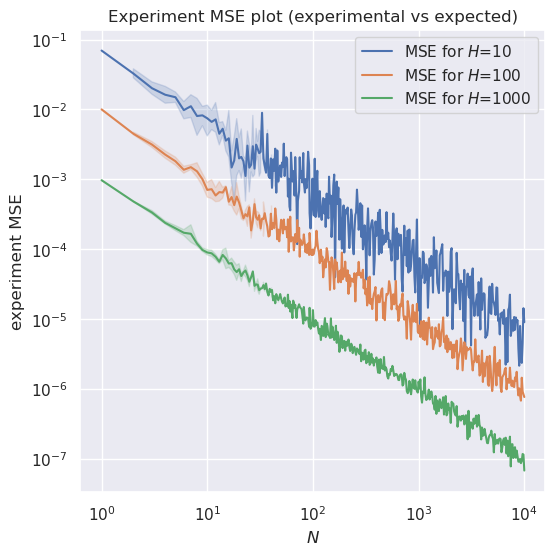

In [15]:
plot_error(Hlist=[10,100,1000], errorname='expected')

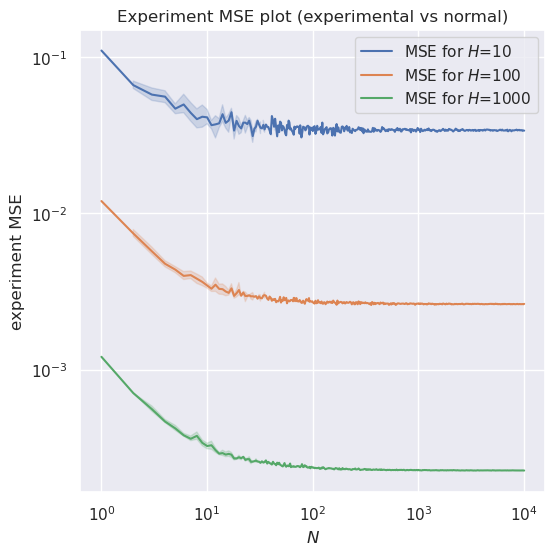

In [16]:
plot_error(Hlist=[10,100,1000], errorname='normal')